In [3]:
import cv2
import numpy as np
import sys
from PIL import Image
import math
import matplotlib.pyplot as plt
sys.path.insert(0, '/Users/ebiharamari/Sources/spherical_warper_pybind/build/')
import spherical_warper

objc[29513]: Class CaptureDelegate is implemented in both /Users/marimurotani/.pyenv/versions/3.13.0/envs/spherical-warp-env/lib/python3.13/site-packages/cv2/cv2.abi3.so (0x11983e518) and /opt/homebrew/Cellar/opencv/4.11.0_1/lib/libopencv_videoio.4.11.0.dylib (0x11e714848). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[29513]: Class CVWindow is implemented in both /Users/marimurotani/.pyenv/versions/3.13.0/envs/spherical-warp-env/lib/python3.13/site-packages/cv2/cv2.abi3.so (0x11983e568) and /opt/homebrew/Cellar/opencv/4.11.0_1/lib/libopencv_highgui.4.11.0.dylib (0x11dd60b28). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[29513]: Class CVView is implemented in both /Users/marimurotani/.pyenv/versions/3.13.0/envs/spherical-warp-env/lib/python3.13/site-packages/cv2/cv2.abi3.so (0x11983e590) and /opt/homebrew/Cellar/opencv/4.11.0_1/lib/libopen

In [4]:
import sys
print(sys.version)
print(sys.executable)

3.13.0 (main, May 31 2025, 16:20:09) [Clang 17.0.0 (clang-1700.0.13.5)]
/Users/marimurotani/.pyenv/versions/3.13.0/envs/spherical-warp-env/bin/python


In [5]:
def rotation_matrix_yaw_pitch(yaw_deg, pitch_deg):
    """Yaw（水平）とPitch（垂直）から回転行列Rを生成"""
    yaw = math.radians(yaw_deg)
    pitch = math.radians(pitch_deg)

    # yaw方向のrotation行列
    Ry = np.array([
        [math.cos(yaw), 0, math.sin(yaw)],
        [0, 1, 0],
        [-math.sin(yaw), 0, math.cos(yaw)],
    ])

    # pitch方向のrotation行列
    Rx = np.array([
        [1, 0, 0],
        [0, math.cos(pitch), -math.sin(pitch)],
        [0, math.sin(pitch), math.cos(pitch)],
    ])

    # Rx @ Ry → 行列の積（回転行列の合成)
    return (Rx @ Ry).tolist()

In [6]:
def rotation_to_equirectangular_xy(R, width, height):
    """回転行列Rが向いている方向をequirectangular座標(px, py)に変換"""
    forward = np.dot(np.array(R).T, np.array([0, 0, 1]))
    x, y, z = forward
    theta = math.asin(y)            # 緯度 [-π/2, π/2]
    phi = math.atan2(x, z)          # 経度 [-π, π]
    px = int((phi + math.pi) / (2 * math.pi) * width)
    py = int((math.pi / 2 - theta) / math.pi * height)
    return px, py

Input image shape: (340, 508, 3)
Canvas shape: (512, 1024, 4)


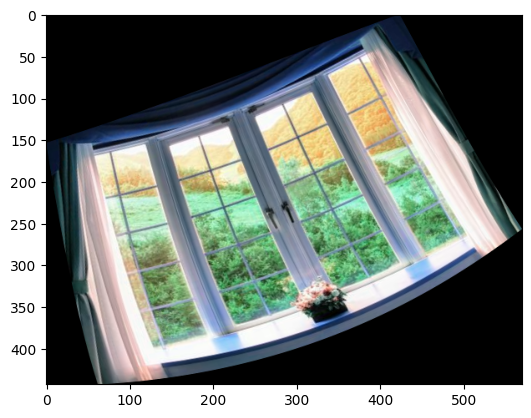

In [14]:
img = cv2.imread('window.jpeg')
print("Input image shape:", img.shape)

# 入力画像サイズ
H, W = img.shape[:2]

# カメラ行列 K
f = 500.0
K = [[f, 0, W / 2],
     [0, f, H / 2],
     [0, 0, 1]]

# 出力サイズ（equirectangular 2:1）
out_w, out_h = 1024, 512
canvas = np.zeros((out_h, out_w, 4), dtype=np.uint8)
print("Canvas shape:", canvas.shape)

# yaw/pitch を指定して、視野方向の patch を得る
yaw_deg = 45
pitch_deg = -30
R = rotation_matrix_yaw_pitch(yaw_deg, pitch_deg)

warped_patch = spherical_warper.warp_spherical(img, f, K, R)
plt.imshow(warped_patch)